<a href="https://colab.research.google.com/github/dataoscar7/LSTMStockPredictor/blob/main/C%C3%B3digo/LSTM_acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de activos mediante Red Neuronal Recurrente

#### Recolección de datos

A continuación obtenemos las librerías necesarias para desarrollar el modelo y obtenemos los datos en formato csv (Estos datos han sido obtenidos en la aplicación E-Signal)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [36]:
#tickers = ['AAPL_D.csv', 'GDX_D.csv', 'IWM_D.csv', 'XOM_D.csv']
tickers = ['AAPL', 'GDX', 'IWM', 'XOM']
encabezados = ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']

# Diccionario para almacenar los datos de las acciones
datos_acciones = {}

for simbolo in tickers:
    ruta_archivo = f'{simbolo}_D.csv'
    datos = pd.read_csv(ruta_archivo, header=None)
    datos.columns = encabezados
    datos['DATE'] = pd.to_datetime(datos['DATE'], format='%d/%m/%Y')

    # Almacenar los datos en el diccionario
    datos_acciones[simbolo] = datos

# Acceder a los datos de una acción específica
datos_aapl = datos_acciones['AAPL']
datos_gdx = datos_acciones['GDX']
datos_iwm = datos_acciones['IWM']
datos_xom = datos_acciones['XOM']

### Preparación de datos

  Estos pasos nos permiten tener los datos en un formato adecuado para ser utilizados en una red LSTM, donde cada muestra representa un punto en el tiempo y las variables independientes son los precios anteriores.

  Obtenems como resultado de la función los conjuntos de datos de entrenamiento y prueba

  

In [37]:
def preparar_datos_lstm(df, pasos_atras):
    df = df.copy()
    df.set_index('DATE', inplace=True)

    for i in range(1, pasos_atras+1):
        df[f'CLOSE(t-{i})'] = df['CLOSE'].shift(i)

    df.dropna(inplace=True)
    return df

datos = datos_iwm[['DATE', 'CLOSE']]
pasos_atras = 10
datos_analisis = preparar_datos_lstm(datos, pasos_atras)


# Escalamos los datos entre -1 y 1
escalar = MinMaxScaler(feature_range=(-1, 1))
datos_escalados = escalar.fit_transform(datos_analisis)

# Separamos las variable dependiente de las independientes
X = datos_escalados[:, 1:]
y = datos_escalados[:, 0]

# Invertir la matriz X
X = np.flip(X, axis=1)

tamaño_entrenamiento = int(len(X) * 0.95)

X_train = X[:tamaño_entrenamiento]
X_test = X[tamaño_entrenamiento:]
y_train = y[:tamaño_entrenamiento]
y_test = y[tamaño_entrenamiento:]

X_train = X_train.reshape((-1, pasos_atras, 1))
X_test = X_test.reshape((-1, pasos_atras, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train.copy()).float()
y_train = torch.tensor(y_train.copy()).float()
X_test = torch.tensor(X_test.copy()).float()
y_test = torch.tensor(y_test.copy()).float()


Ahora vamos a crear conjuntos de datos personalizados, a partir de los datos de entrenamiento y prueba preparados. Son fundamentales para organizar y estructurar los datos de manera adecuada, permitiendo su uso en el entrenamiento y prueba de la red neuronal.

En lugar de alimentar toda la colección de datos de entrenamiento de una vez,lo dividimos en lotes más pequeños. Estos se procesan de manera independiente, lo que permite un entrenamiento más eficiente y facilita el cálculo de los gradientes para la actualización de los pesos de la red.

In [38]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Conjunto de datos de entrenamiento y prueba
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

tamaño_lote = 20
train_loader = DataLoader(train_dataset, batch_size=tamaño_lote, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=tamaño_lote, shuffle=False)

### Red Neuronal

Definimos la clase LSTM para el procesamiento de secuencias de tiempo. Esta consta de una capa completamente conectada y propagación hacia adelante.

Además, se definen dos funciones utilizadas para entrenar y evaluar la red neuronal LSTM en series de tiempo.

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        # Definición de la capa completamente conectada (fully connected)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        # Inicialización de los estados ocultos h0 y c0 de la LSTM
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Propagación hacia adelante de la entrada x a través de la LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Seleccionamos solo la última secuencia de tiempo de la salida de la LSTM
        out = self.fc(out[:, -1, :])
        return out

def entrenamiento_epoca():
    model.train(True)  # Modo de entrenamiento
    print(f'Época: {epoch + 1}')
    running_loss = 0.0

    avg_loss_across_batches = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Reiniciamos gradientes acumulados y calculamos los gradientes de la
        #pérdida. Luego actualizamos con los gradientes calculados
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Imprimimos el promedio de pérdida cada 100 lotes
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Lote {0}, Pérdida: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0

    loss_history.append(avg_loss_across_batches)

    ### print()

def validacion_epoca():
    model.train(False)  # Modo de evaluación
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():  # Desactivamos el cálculo y almacenamiento de gradientes para ahorrar memoria y tiempo
            output = model(x_batch)  # Pasamos los datos del lote al modelo para obtener las predicciones
            loss = loss_function(output, y_batch)  # Calculamos la pérdida entre las predicciones y las etiquetas reales
            running_loss += loss.item()

    # Calcula el promedio de pérdida en la validación
    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('--------------------------------------------------')
    print()



In [ ]:
# Creamos una lista para almacenar la pérdida en cada época
loss_history = []

# Una instancia del modelo LSTM
model = LSTM(1, 4, 1)
model.to(device)
tasa_aprendizaje = 0.001
num_epocas = 10

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=tasa_aprendizaje)

for epoch in range(num_epocas):
    entrenamiento_epoca()
    validacion_epoca()


La pérdida comienza alta y luego disminuye rápidamente y se va aplanando. Esto nos indica que el modelo está aprendiendo y ajustándose bien a los datos iniciales

Ahora creamos un contexto controlado en el que se garantiza que los recursos se gestionan correctamente. Esto asegura que no se realicen cálculos de gradiente durante el cálculo de las predicciones, ya que solo deseamos las predicciones.

### Visualización del modelo

##### Código necesario para visualizar

In [41]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

In [42]:
# Desescalamos los datos de entrenamiento
train_predictions = predicted.flatten()

base = np.zeros((X_train.shape[0], pasos_atras+1))
base[:, 0] = train_predictions
base = escalar.inverse_transform(base)

train_predictions = dc(base[:, 0])

base = np.zeros((X_train.shape[0], pasos_atras+1))
base[:, 0] = y_train.flatten()
base = escalar.inverse_transform(base)

new_y_train = dc(base[:, 0])

In [43]:
# Desescalamos los datos de prueba
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
base = np.zeros((X_test.shape[0], pasos_atras+1))
base[:, 0] = test_predictions
base = escalar.inverse_transform(base)

test_predictions = dc(base[:, 0])

base = np.zeros((X_test.shape[0], pasos_atras+1))
base[:, 0] = y_test.flatten()
base = escalar.inverse_transform(base)

new_y_test = dc(base[:, 0])

In [44]:
sns.set(style='darkgrid')
# Calcular el error absoluto entre los precios desescalados
error_absoluto = np.abs(new_y_test.flatten() - test_predictions.flatten())

# Obtener las fechas correspondientes a los datos de validación
fechas_validación = datos['DATE'][tamaño_entrenamiento+pasos_atras:].reset_index(drop=True)

##### Gráfico predicción y error absoluto

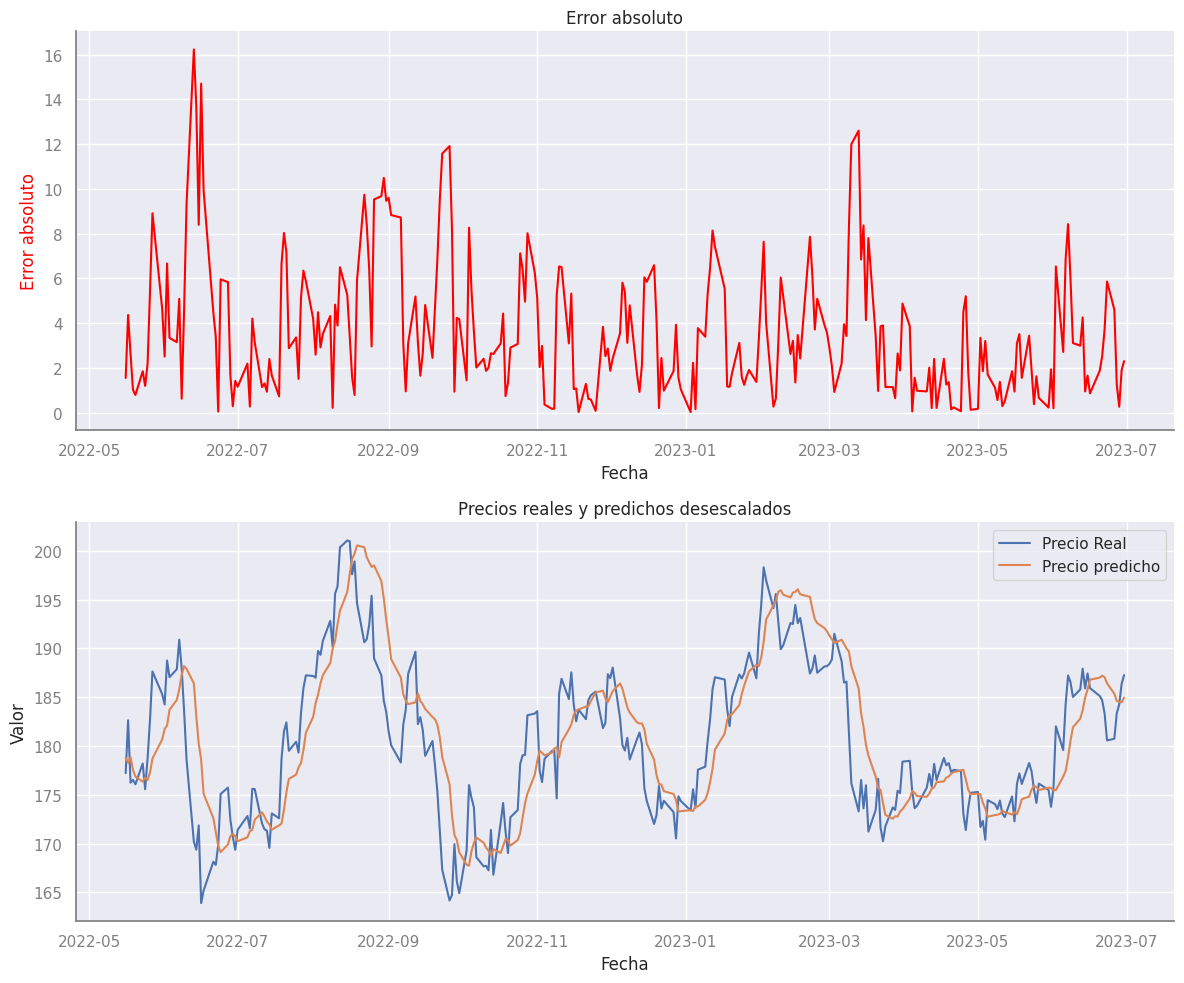

In [45]:
# Hacemos el gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Primer gráfico: Error absoluto
ax1.plot(fechas_validación, error_absoluto, color='red')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Error absoluto', color='red')
ax1.set_title('Error absoluto')

# Segundo gráfico: Precios reales y predichos desescalados
ax2.plot(fechas_validación, new_y_test.flatten(), label='Precio Real')
ax2.plot(fechas_validación, test_predictions.flatten(), label='Precio predicho')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Valor')
ax2.set_title('Precios reales y predichos desescalados')
ax2.legend()

# Ajustar estilo y colores de los ejes y bordes
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    ax.tick_params(axis='y', colors='gray')

fig.tight_layout()
plt.show()

##### Gráfico entrenamiento

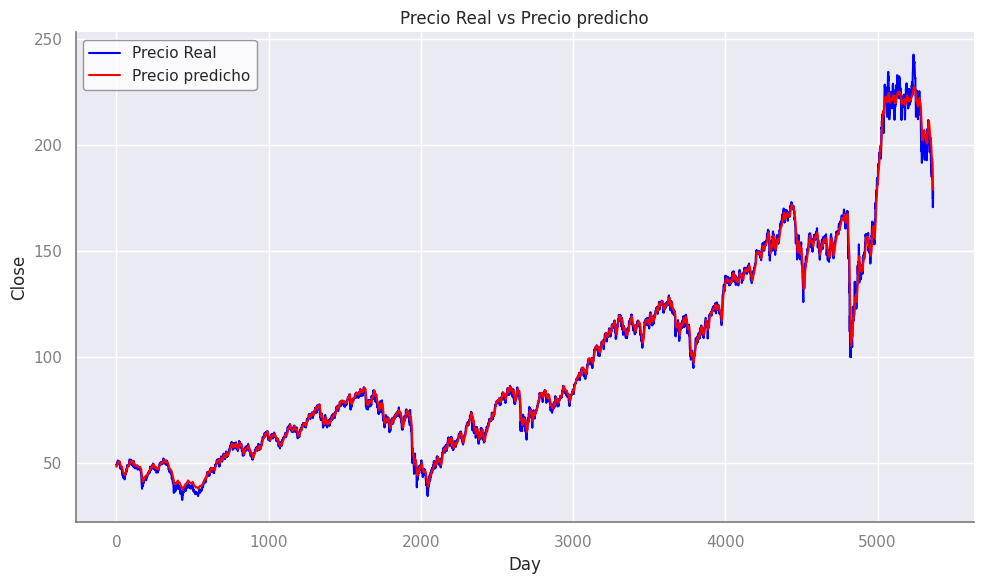

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(new_y_train, color='blue', label='Precio Real')
ax.plot(train_predictions, color='red', label='Precio predicho')
ax.set_xlabel('Day')
ax.set_ylabel('Close')
ax.set_title('Precio Real vs Precio predicho')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

legend = ax.legend(frameon=True, facecolor='white', edgecolor='gray')
fig.tight_layout()

plt.show()

##### Evolución de la pérdida en entrenamiento

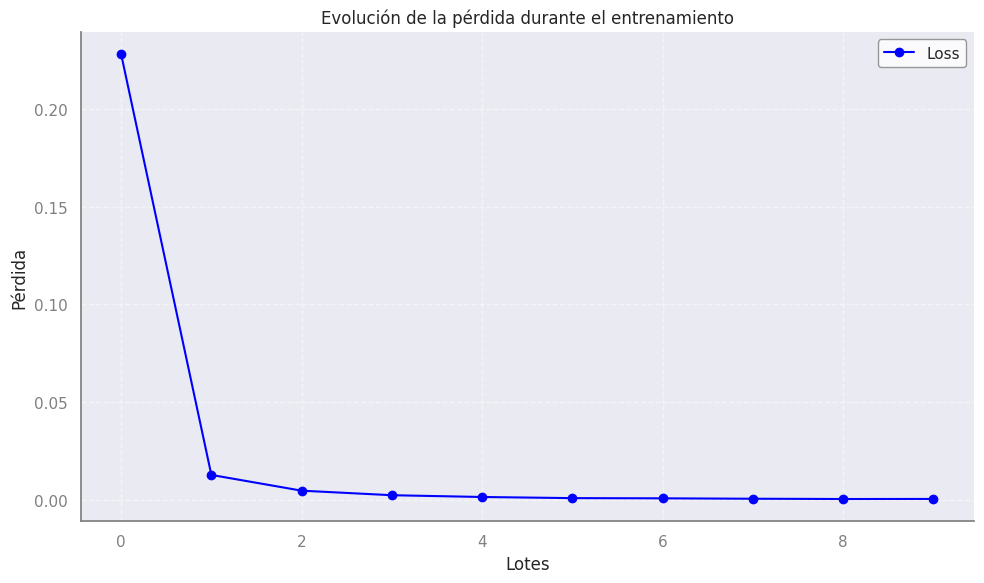

In [47]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar la pérdida acumulada
ax.plot(loss_history, '-o', color='blue', label='Loss')

# Establecer etiquetas de los ejes y título del gráfico
ax.set_xlabel('Lotes')
ax.set_ylabel('Pérdida')
ax.set_title('Evolución de la pérdida durante el entrenamiento')

# Mostrar la leyenda
ax.legend()

# Configuraciones adicionales de los ejes y la leyenda
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')
legend = ax.legend(frameon=True, facecolor='white', edgecolor='gray')

# Ajustar el diseño de la figura
fig.tight_layout()

# Mostrar el gráfico
plt.show()